In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

class manualOLS:
    def __init__(self, X, y, addIntercept=True, method='byhand', useRobust=False):
        '''
        This class implements the OLS estimator using different methods: 'byhand', 'leastsquares', and 'statsmodels'
        '''
        self.X = X
        self.y = y
        self.method = method
        self.addIntercept = addIntercept
        self.useRobust = useRobust
        
        if self.X.ndim==1:
            self.X = self.X[:,np.newaxis]
        if self.y.ndim==1:
            self.y = self.y[:,np.newaxis]
        if self.addIntercept:
            self.X = np.concatenate((self.X, np.ones((self.X.shape[0],1))), axis=1)
        
        self.xxinv= np.linalg.inv(self.X.T @ self.X)
        self.n,self.k=self.X.shape
        
    def beta(self):
        if self.method=='byhand':
            beta = self.xxinv @ self.X.T @ self.y
            
        elif self.method=='leastsquares':
            def ssr(b, X, y):
                return np.sum(np.square(y-X@b[:,np.newaxis]))
            beta=minimize(ssr, x0=np.zeros((self.X.shape[1],1)), args=(self.X, self.y)).x[:,np.newaxis]
            
        elif self.method=='statsmodels':
            import statsmodels.api as sm
            beta = sm.OLS(self.y, self.X).fit().params[:,np.newaxis]
            
        else:
            raise ValueError('Method not recognized')
        
        return beta
    
    def beta_std(self):
        cov=self.cov()
        beta_std=np.sqrt(np.diag(cov))[:,np.newaxis]
        return beta_std
    
    def cov(self):
        yhat=self.predict()
        e=self.y-yhat
        s2=e.T@e/(self.n-self.k)
        
        if self.useRobust:
            cov=(self.n/(self.n-self.k))*self.xxinv @ (self.X.T @ np.diag(np.diag(e @ e.T)) @self.X) @self.xxinv
        else:
            cov=s2*self.xxinv
        return cov
    
    def MSE(self):
        yhat=self.predict()
        e=self.y-yhat
        s2=e.T@e/(self.n-self.k)
        MSE=np.sqrt(s2)[0,0]
        return MSE
    
    
    def predict(self):
        yhat=self.X@self.beta()
        return yhat
    
    def R2(self):
        y_hat = self.predict()
        return np.sum((y_hat - self.y)**2) / np.sum((self.y - np.mean(self.y))**2)
    
    def report(self):
        print('Regression using {:s} method'.format(self.method))
        print('Number of observations: {:d}\nNumber of parameters: {:d}'.format(self.n,self.k))
        print('OLS estimates (standard errors in parentheses):')
        
        if type(self.X)==pd.core.frame.DataFrame:
            colnames=np.concatenate(pd.Series(self.X.columns.tolist()),pd.Series(['cons']))[:,np.newaxis]
            for col,b,std in zip(colnames,self.beta(),self.beta_std()):
                b=b[0]
                std=std[0]
                print('{:s} {:1.5f} ({:1.5f})'.format(col,b,std))
        else:
            #colnames=self.X.columns.tolist()
            #colnames=colnames+['cons']
            for b,std in zip(self.beta(),self.beta_std()):
                b=b[0]
                std=std[0]
                print('{:1.5f} ({:1.5f})'.format(b,std))
        print('MSE = {:1.5f}'.format(self.MSE()))
        print('R2 = {:1.5f}\n'.format(self.R2()))
                

In [109]:
# test with simple data
X = np.array([1,2,3,4,5,6,7,8,9,10])
y = np.array([9.4,8.1,7.7,6.3,5.7,4.4,3.0,2.1,1.1,0.8])

manualOLS(X,y,method='statsmodels').report()
manualOLS(X,y,method='byhand').report()
manualOLS(X,y,method='leastsquares').report()

Regression using statsmodels method
Number of observations: 10
Number of parameters: 2
OLS estimates (standard errors in parentheses):
-1.00364 (0.03400)
10.38000 (0.21096)
MSE = 0.30881
R2 = 0.00910

Regression using byhand method
Number of observations: 10
Number of parameters: 2
OLS estimates (standard errors in parentheses):
-1.00364 (0.03400)
10.38000 (0.21096)
MSE = 0.30881
R2 = 0.00910

Regression using leastsquares method
Number of observations: 10
Number of parameters: 2
OLS estimates (standard errors in parentheses):
-1.00364 (0.03400)
10.38000 (0.21096)
MSE = 0.30881
R2 = 0.00910



C:\Users\mramadhani3\AppData\Local\Temp\ipykernel_184204\4091307649.py:33: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  beta=minimize(ssr, x0=np.zeros((self.X.shape[1],1)), args=(self.X, self.y)).x[:,np.newaxis]


In [61]:

manualOLS(X,y,method='statsmodels').predict()

array([[9.37636364],
       [8.37272727],
       [7.36909091],
       [6.36545455],
       [5.36181818],
       [4.35818182],
       [3.35454545],
       [2.35090909],
       [1.34727273],
       [0.34363636]])

In [11]:
datapath = r'C:\Users\mramadhani3\OneDrive - Georgia Institute of Technology\Documents\Spring-24\environmental-econ-ii\phdee-24-MR\homework-2\data'
outputpath = r'C:\Users\mramadhani3\OneDrive - Georgia Institute of Technology\Documents\Spring-24\environmental-econ-ii\phdee-24-MR\homework-2\output'
kwh=pd.read_csv(datapath +'/kwh.csv')
manualOLS(kwh[['retrofit','sqft','temp']],kwh['electricity'],method='byhand',useRobust=True).report()
manualOLS(kwh[['retrofit','sqft','temp']],kwh['electricity'],method='statsmodels').report()
#manualOLS(kwh[['sqft','retrofit','temp']],kwh['electricity'],method='leastsquares').report()

Regression using byhand method
Number of observations: 1000
Number of parameters: 4
OLS estimates (standard errors in parentheses):
-109.66618 (7.94294)
0.61534 (0.00678)
3.25508 (1.93170)
-83.60276 (154.69496)
MSE = 125.65209
R2 = 0.08066

Regression using statsmodels method
Number of observations: 1000
Number of parameters: 4
OLS estimates (standard errors in parentheses):
-109.66618 (7.94823)
0.61534 (0.00581)
3.25508 (1.92383)
-83.60276 (154.35957)
MSE = 125.65209
R2 = 0.08066



C:\Users\mramadhani3\AppData\Local\Temp\ipykernel_218316\2621120571.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.y = self.y[:,np.newaxis]
C:\Users\mramadhani3\AppData\Local\Temp\ipykernel_218316\2621120571.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.y = self.y[:,np.newaxis]


In [439]:
type(kwh)==pd.core.frame.DataFrame

True

In [412]:
kwh.columns

Index(['electricity', 'sqft', 'retrofit', 'temp'], dtype='object')

In [352]:
from scipy import stats

retro=kwh.loc[kwh['retrofit']==1].drop('retrofit',axis=1)
noretro=kwh.loc[kwh['retrofit']==0].drop('retrofit',axis=1)

# Generate a table of means and standard deviations for the observed variables (there are faster ways to do this that are less general)
## Generate means and standard deviations
means_control = noretro.mean()
stdev_control = noretro.std()
nobs_control = pd.Series(noretro.count().min())

means_treatment_1 = retro.mean()
stdev_treatment = retro.std()
nobs_treatment = pd.Series(retro.count().min())

## Compute P-values and t-statistics
p_vals = []
t_stats = []    
for col in retro.columns:
    p_vals.append(stats.ttest_ind(retro[col],noretro[col])[1])
    t_stats.append(stats.ttest_ind(retro[col],noretro[col])[0])
p_vals = pd.Series(p_vals, index = retro.columns)
t_stats = pd.Series(t_stats, index = retro.columns)

## Set the row and column names
rownames = pd.concat([pd.Series(['Electricity','Square feet of home','Outdoor average temperature', 'Observations']),
                      pd.Series([' ',' ',' '])],axis = 1).stack() # Note this stacks an empty list to make room for stdevs

## Format means and std devs to display to two decimal places
means_control = means_control.map('{:.2f}'.format)
stdev_control = stdev_control.map('({:.2f})'.format)
nobs_control = nobs_control.map('{:.0f}'.format)

means_treatment = means_treatment_1.map('{:.2f}'.format)
stdev_treatment = stdev_treatment.map('({:.2f})'.format)
nobs_treatment = nobs_treatment.map('{:.0f}'.format)

p_vals = p_vals.map('{:.3f}'.format)
t_stats = t_stats.map('[{:.3f}]'.format)

## Align std deviations under means and add observations
col1 = pd.concat([means_control,stdev_control,nobs_control],axis = 1).stack()
col2 = pd.concat([means_treatment,stdev_treatment,nobs_treatment],axis = 1).stack()
col3 = pd.concat([p_vals,t_stats,pd.Series([' '])],axis = 1).stack()
##------------------------------------------------------------

## Add column and row labels.  Convert to dataframe (helps when you export it)
col = pd.DataFrame({'Control': col1, 'Treatment': col2, 'P-value': col3})
col.index = rownames
col.to_latex(outputpath + '/table/table1.tex',column_format='lccc',escape=False)


C:\Users\mramadhani3\AppData\Local\Temp\ipykernel_208616\1357716566.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  col.to_latex(outputpath + '/table/table1.tex',column_format='lccc',escape=False)


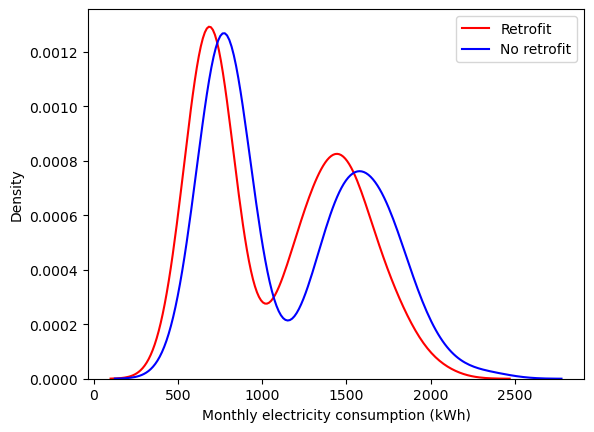

In [244]:
# Plot a histogram of the outcome variable -----------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

fig = sns.kdeplot(retro['electricity'], color="r")
fig = sns.kdeplot(noretro['electricity'], color="b")
plt.xlabel('Monthly electricity consumption (kWh)')
plt.legend(labels = ['Retrofit','No retrofit'],loc = 'best')
plt.show
plt.savefig(outputpath + '/figure/2_hist.pdf',format='pdf')